# 機械学習手法(scikit-learn)

## Irisデータセットの読み込み

In [4]:
# モジュールの読み込み
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [6]:
# 訓練データと検証データに分割
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y)

In [8]:
# データの分割状況を確認
print('y:', np.bincount(y))
print('y_train:', np.bincount(y_train))
print('y_test:', np.bincount(y_test))

y: [50 50 50]
y_train: [40 40 40]
y_test: [10 10 10]


In [9]:
# 標準化
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

## Perceptron

In [14]:
from sklearn.linear_model import Perceptron

per = Perceptron(eta0=0.01, random_state=3)
per.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.01,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=3, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
# モデル適合
y_pred = per.predict(X_test_std)
print('間違ったサンプル数: %d' % (y_test != y_pred).sum())

間違ったサンプル数: 6


In [16]:
# 混合行列 正解率
from sklearn.metrics import accuracy_score

print('正解率: %.3f' % accuracy_score(y_test, y_pred))

正解率: 0.800


In [18]:
print('正解率: %.3f' % per.score(X_test_std, y_test))

正解率: 0.800


## 決定境界の関数

In [23]:
# モジュールの読み込み
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# seabornのスタイルを適合
sns.set()
sns.set_style('whitegrid')

# 決定境界
def plot_decision_line(X, y, classifier, test_idx=None, resolution=0.02):

    # マーカーとカラーマップの設定
    markers = ('s', 'x', 'o', '^', 'v')
    sensy_accent =  ('#5073ED', '#FA8EB5', '#A7C0FD', '#4B4C80', '#F4458C')
    #np.unique()は重複を削除した配列
    cmap = ListedColormap(sensy_accent[:len(np.unique(y))])

    # 決定領域
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    #predictで予測
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    #reshapeで配列の形状を変更
    Z = Z.reshape(xx1.shape)
    #contourf()は等高線を表す
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    #x軸とy軸の範囲を制限
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # クラスごとに訓練データをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=sensy_accent[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # テストサンプルを目立たせる
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


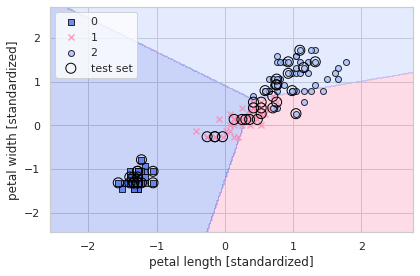

In [24]:
# vstack関数は、2次元でいうと縦方向(vertical)に連結 axis=0
X_combined_std = np.vstack((X_train_std, X_test_std))
# hstack関数は、2次元でいうと、水平方向に(horizontal)連結 axis=1
y_combined = np.hstack((y_train, y_test))

plot_decision_line(X=X_combined_std, y=y_combined,
                      classifier=per, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## ロジスティック回帰

In [30]:
# ロジスティック回帰の関数
class LogisticRegressionGD(object):
    #　コンストラクタ
    def __init__(self, lr=0.01, n_iter=100, random_state=3):
        self.lr = lr
        self.n_iter = n_iter
        self.random_state = random_state

    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        # 訓練回数分まで繰り返し処理
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.lr * X.T.dot(errors)
            self.w_[0] += self.lr * errors.sum()

            # 誤差
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    # 総入力の計算
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    # 活性化関数
    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    # 分類器
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

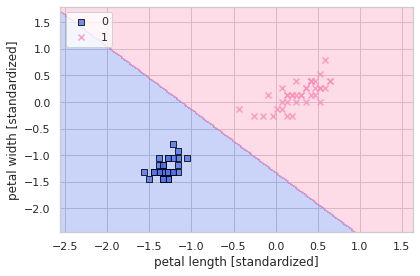

In [31]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(lr=0.02, n_iter=3000, random_state=3)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_line(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()

#可視化
plt.show()

### ロジスティック回帰　学習

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


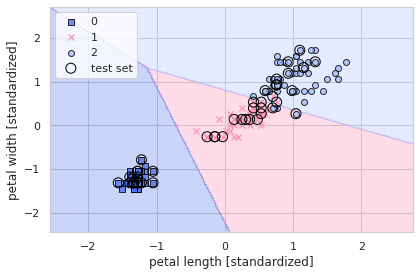

In [38]:
# モジュールの読み込み
from sklearn.linear_model import LogisticRegression

logi = LogisticRegression(C=100.0, random_state=1, solver='lbfgs', multi_class='ovr')
logi.fit(X_train_std, y_train)

plot_decision_line(X_combined_std, y_combined,
                      classifier=logi, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

#可視化
plt.show()

### ロジスティック回帰　予測結果

In [39]:
logi.predict_proba(X_test_std[:3, :])

array([[1.53025271e-10, 1.12481076e-01, 8.87518924e-01],
       [6.21783905e-04, 9.98030037e-01, 1.34817922e-03],
       [3.75559960e-07, 3.24547271e-01, 6.75452353e-01]])

In [40]:
logi.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [41]:
logi.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 1, 2])

In [42]:
logi.predict(X_test_std[:3, :])

array([2, 1, 2])

In [43]:
logi.predict(X_test_std[0, :].reshape(1, -1))

array([2])

## サポートベクターマシン

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


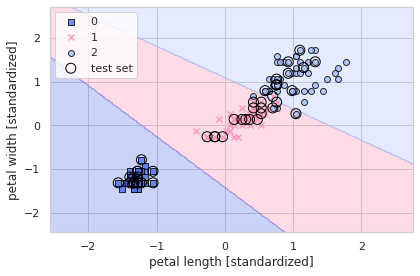

In [50]:
# モジュール読み込み
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_line(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

#　可視化
plt.show()

In [52]:
# それぞれの手法を使用する方法
from sklearn.linear_model import SGDClassifier

per = SGDClassifier(loss='perceptron')
logi = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')

## カーネルサポートベクターマシン

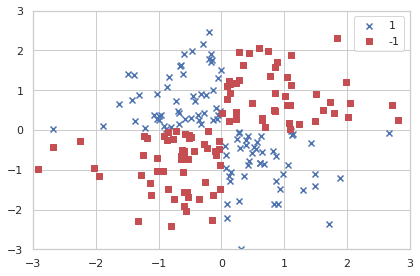

In [53]:
# モジュールの読み込み
import matplotlib.pyplot as plt
import numpy as np

# 乱数を生成
np.random.seed(3)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()

# 可視化
plt.show()

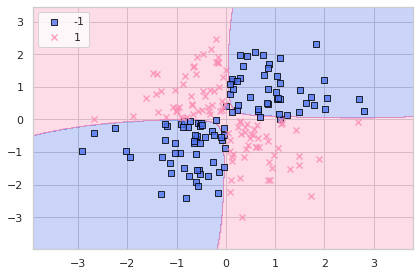

In [54]:
# カーネルSVC
svm = SVC(kernel='rbf', random_state=3, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_line(X_xor, y_xor, classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()

# 可視化
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


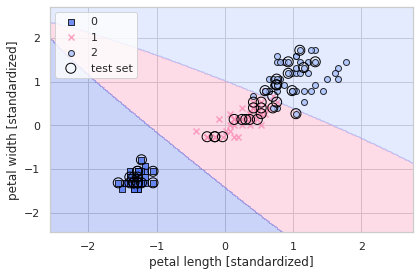

In [56]:
# カーネルSVC
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=3, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_line(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

# 可視化
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


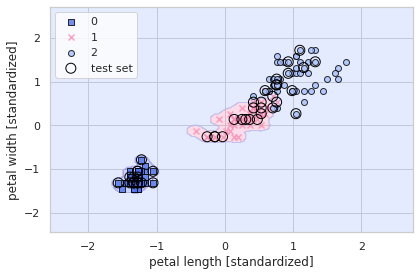

In [57]:
# カーネルSVC
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_line(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

# 可視化
plt.show()

## 決定木

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


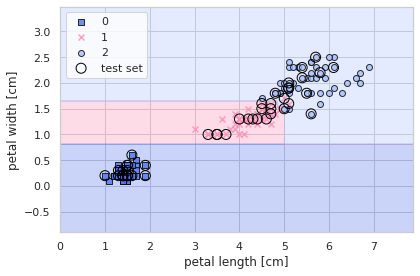

In [59]:
# 決定木
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
# モデルを適合
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_line(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()

# 可視化
plt.show()

### ランダムフォレスト

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


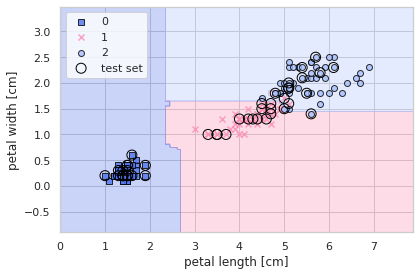

In [60]:
# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
# モデルを適合
forest.fit(X_train, y_train)

plot_decision_line(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()

# 可視化
plt.show()

<br>
<br>

## 最近傍法

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


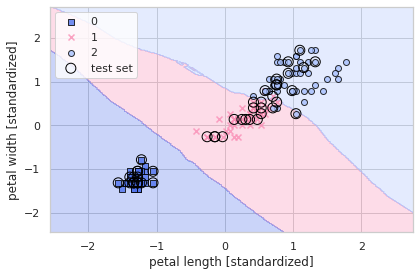

In [61]:
# 最近傍法
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_line(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()

# 可視化
plt.show()